In [1]:
import pyreadr
import scanpy as sc
import numpy as np
import os
import pandas as pd
import anndata as ad
import scrublet as scr
from pathlib import Path

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

In [2]:
# where to save the file and filename to give
DIR2SAVE = Path("/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/20mt/scrublet_qc/")
scrublet_filename = "Wu2022_CRC_scrublet.txt"

# figures path to save
FIG2SAVE = DIR2SAVE.joinpath("figures/")
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [3]:
adata = sc.read_h5ad(
    "/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/raw/Wu2022_CRC_raw.h5ad"
)

In [4]:
set(adata.obs.Tissue)

{'CRC'}

In [5]:
set(adata.obs.Patient)

{'Wu2021_P1',
 'Wu2021_P10',
 'Wu2021_P11',
 'Wu2021_P12',
 'Wu2021_P15',
 'Wu2021_P16',
 'Wu2021_P17',
 'Wu2021_P18',
 'Wu2021_P19',
 'Wu2021_P2',
 'Wu2021_P20',
 'Wu2021_P3',
 'Wu2021_P4',
 'Wu2021_P5',
 'Wu2021_P6',
 'Wu2021_P7',
 'Wu2021_P8',
 'Wu2021_P9'}

In [6]:
len(set(adata.obs.Sample))

18

In [7]:
adata.obs[["Therapy", "Patient"]].groupby("Therapy").size()

Therapy
NAC      12363
naive    17493
dtype: int64

In [8]:
# see how many patients are untreated vs NAC
adata.obs[["Therapy", "Patient"]].drop_duplicates(
    subset=["Therapy", "Patient"], inplace=False
).groupby("Therapy").size()

Therapy
NAC       7
naive    11
dtype: int64

### run scrublet per sample and on raw data
* When working with data from multiple samples, run Scrublet on each sample separately. Because Scrublet is designed to detect technical doublets formed by the random co-encapsulation of two cells, it may perform poorly on merged datasets where the cell type proportions are not representative of any single sample.

In [9]:
adata.obs

,Sample,nCount_RNA,nFeature_RNA,patient,tissue,patient_tissue,tissueunique,RNA_snn_res.0.5,seurat_clusters,RNA_snn_res.0.1,doublet,RNA_snn_res.1,Cell_type,Cell_subtype,chemo,Therapy,Patient,Tissue
barcode,,,,,,,,,,,,,,,,,,
P5_Colon_T_CTGCAGGCATGAGTAA,P5_Colon_T,1803,807,P5,Colon_T,P5_Colon_T,Colon_T,2,2,0,Singlet,5,CD4,CD4+ Naive T cells,treated-PR,NAC,Wu2021_P5,CRC
P10_Colon_T_CCCTAACAGAGGGTAA,P10_Colon_T,3239,1416,P10,Colon_T,P10_Colon_T,Colon_T,0,0,0,Singlet,5,CD8,CTLA4+ CD8+ T cells,pretreated,naive,Wu2021_P10,CRC
P12_Colon_T_AGAAGTAAGGCCCACT,P12_Colon_T,2949,1127,P12,Colon_T,P12_Colon_T,Colon_T,0,0,0,Singlet,3,Treg,FOXP3+ Treg,pretreated,naive,Wu2021_P12,CRC
P10_Colon_T_AGTAGCTGTTTAGAGA,P10_Colon_T,8744,2421,P10,Colon_T,P10_Colon_T,Colon_T,0,0,0,Singlet,2,MAIT,MAIT cells,pretreated,naive,Wu2021_P10,CRC
P12_Colon_T_CAGCCAGTCAAGTGTC,P12_Colon_T,2493,1112,P12,Colon_T,P12_Colon_T,Colon_T,0,0,0,Singlet,4,CD8,GZMK+ CD8+ T cells,pretreated,naive,Wu2021_P12,CRC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P17_Colon_T_TTCTGTAGTGCATTAC-1,P17_Colon_T,1686,757,P17,Colon_T,P17_Colon_T,Colon_T,3,3,2,Singlet,23,B,AIM2+ Memory B cells,pretreated,naive,Wu2021_P17,CRC
P19_Colon_T_ATCGTAGTCGCAGATT-1,P19_Colon_T,3449,1066,P19,Colon_T,P19_Colon_T,Colon_T,3,3,2,Singlet,23,B,AIM2+ Memory B cells,treated-PD/SD,NAC,Wu2021_P19,CRC
P19_Colon_T_GTGTGGCGTCCCTAAA-1,P19_Colon_T,2904,831,P19,Colon_T,P19_Colon_T,Colon_T,3,3,2,Singlet,23,B,TCL1A+ Naive B cells,treated-PD/SD,NAC,Wu2021_P19,CRC


#### Check that the data is raw 

In [10]:
adata.X[1:5, 1:5]

<4x4 sparse matrix of type '<class 'numpy.float32'>'
	with 0 stored elements in Compressed Sparse Row format>

In [11]:
np.max(adata.X)

43586.0

#### run scrublet
scr.scrub_doublets() simulates doublets from the observed data and uses a k-nearest-neighbor classifier to calculate a continuous doublet_score (between 0 and 1) for each transcriptome. The score is automatically thresholded to generate predicted_doublets, a boolean array that is True for predicted doublets and False otherwise.

In [12]:
def run_scrublet(adata, sample_col="Sample", cellbarcode_index_name="level_1"):
    # create dict that stores scrublet results from each sample in adata
    scrublet_dict = {k: None for k in list(set(adata.obs[sample_col]))}

    # run scrublet per sample
    for sample in scrublet_dict.keys():
        print("Sample:", sample)
        adata_tmp = adata[adata.obs[sample_col] == sample].copy()
        scrub = scr.Scrublet(adata_tmp.X)
        (
            adata_tmp.obs["doublet_score"],
            adata_tmp.obs["predicted_doublet"],
        ) = scrub.scrub_doublets()
        scrub.plot_histogram()
        # sc.external.pp.scrublet(adata_tmp)
        scrublet_dict[sample] = adata_tmp.obs[
            ["Sample", "doublet_score", "predicted_doublet"]
        ]
        # sc.external.pl.scrublet_score_distribution(adata_tmp)

    # Put all scores in a single panda dataframe
    scrublet_concat = (
        pd.concat(scrublet_dict, axis=0)
        .reset_index()
        .drop(labels="level_0", axis=1)
        .set_index(cellbarcode_index_name)
    )

    return scrublet_concat

Sample: P18_Colon_T
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 19.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.9%
Elapsed time: 2.0 seconds
Sample: P12_Colon_T
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 18.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.4%
Elapsed time: 0.5 seconds
Sample: P17_Colon_T
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest nei

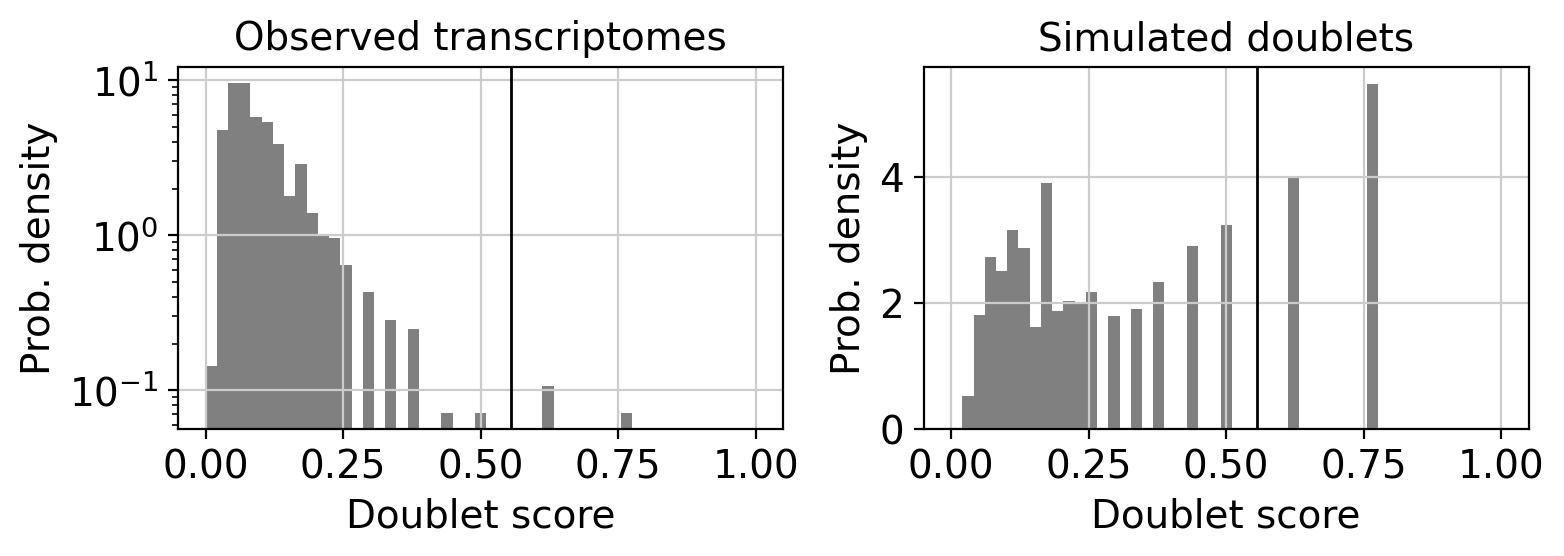

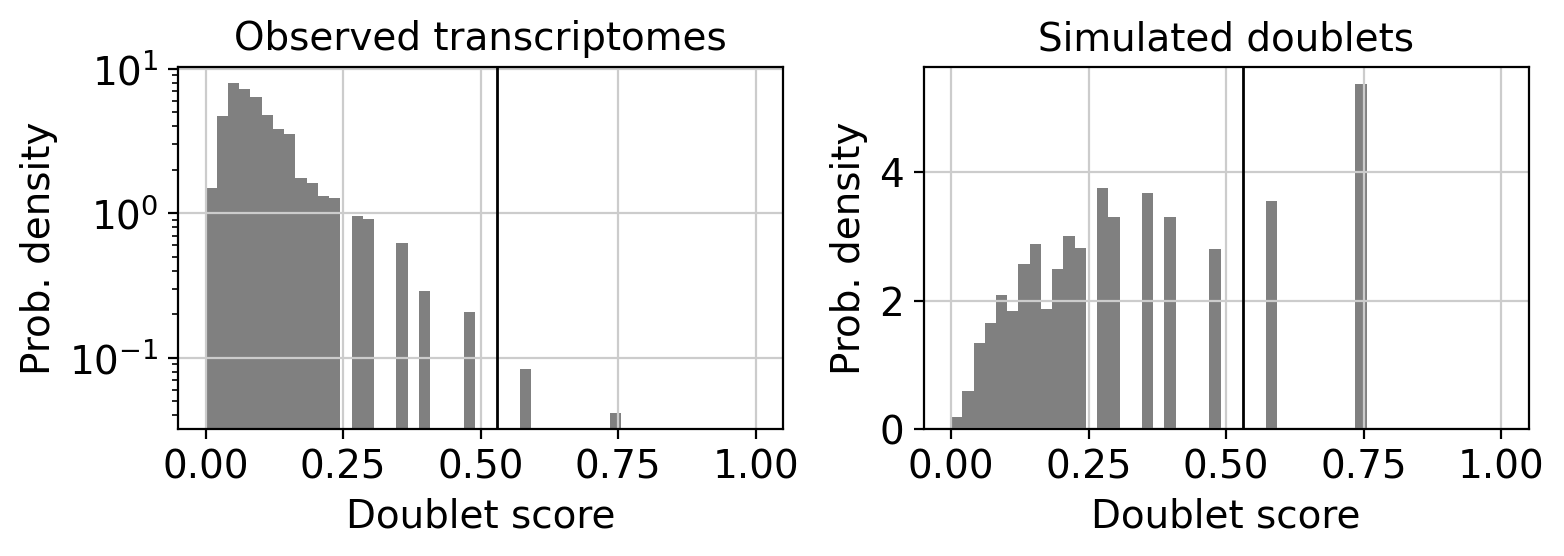

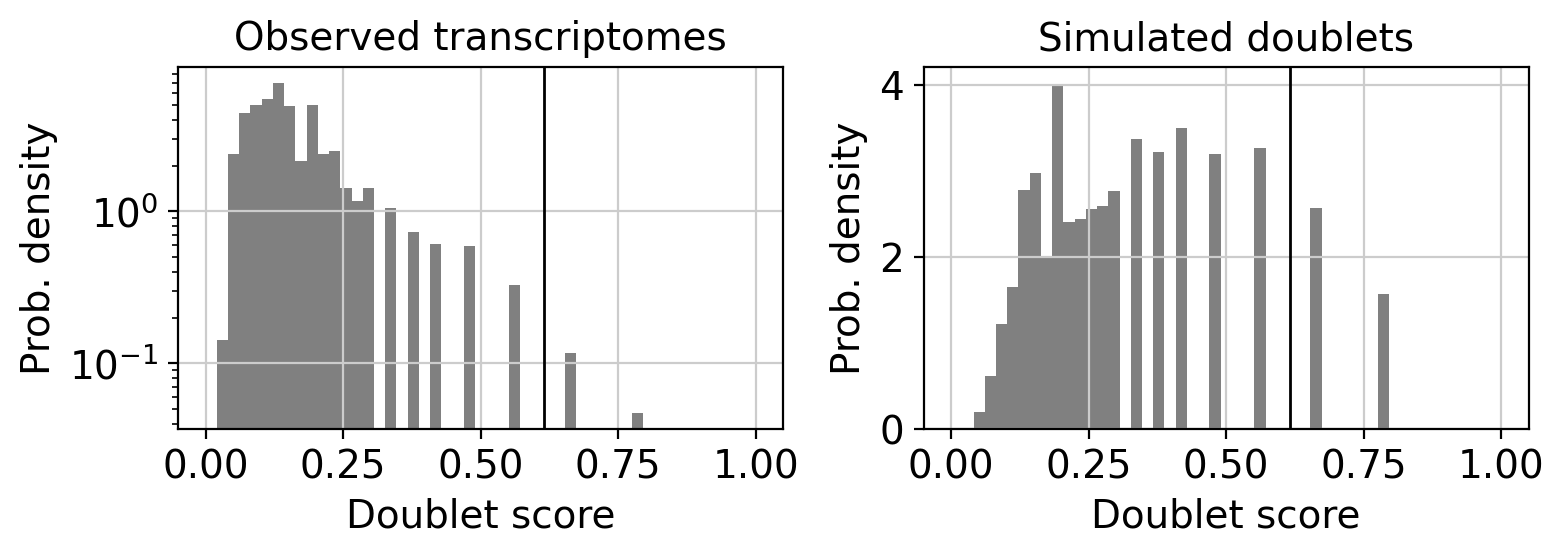

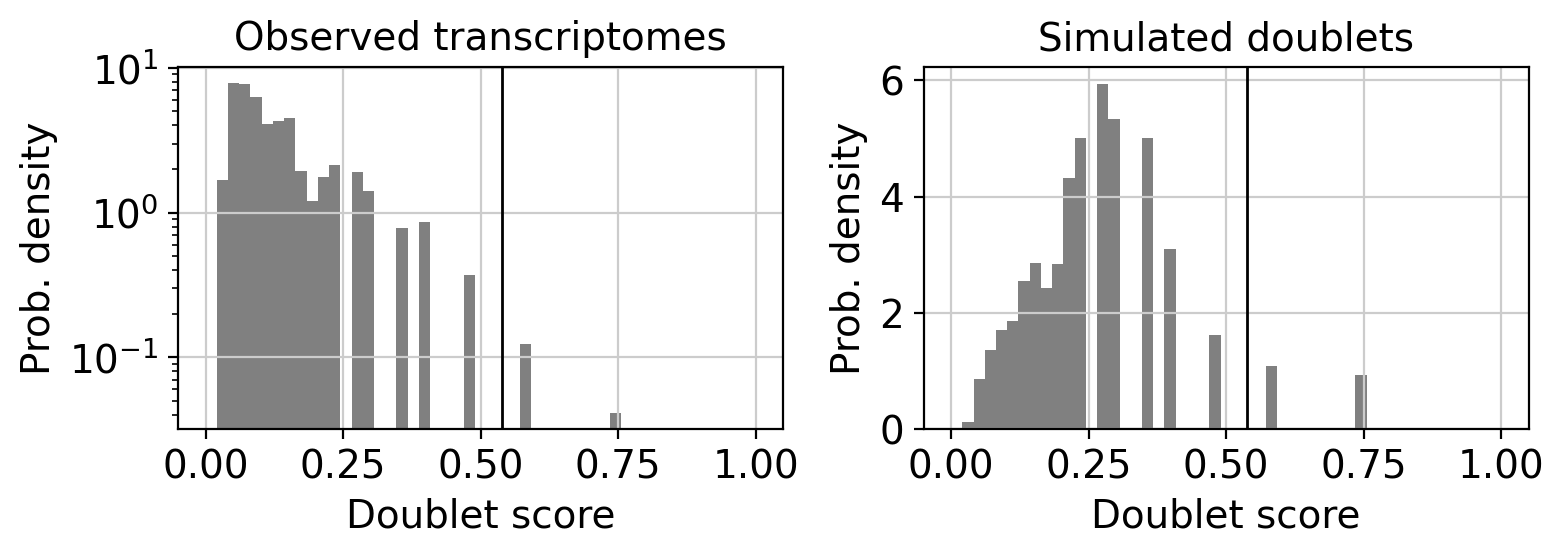

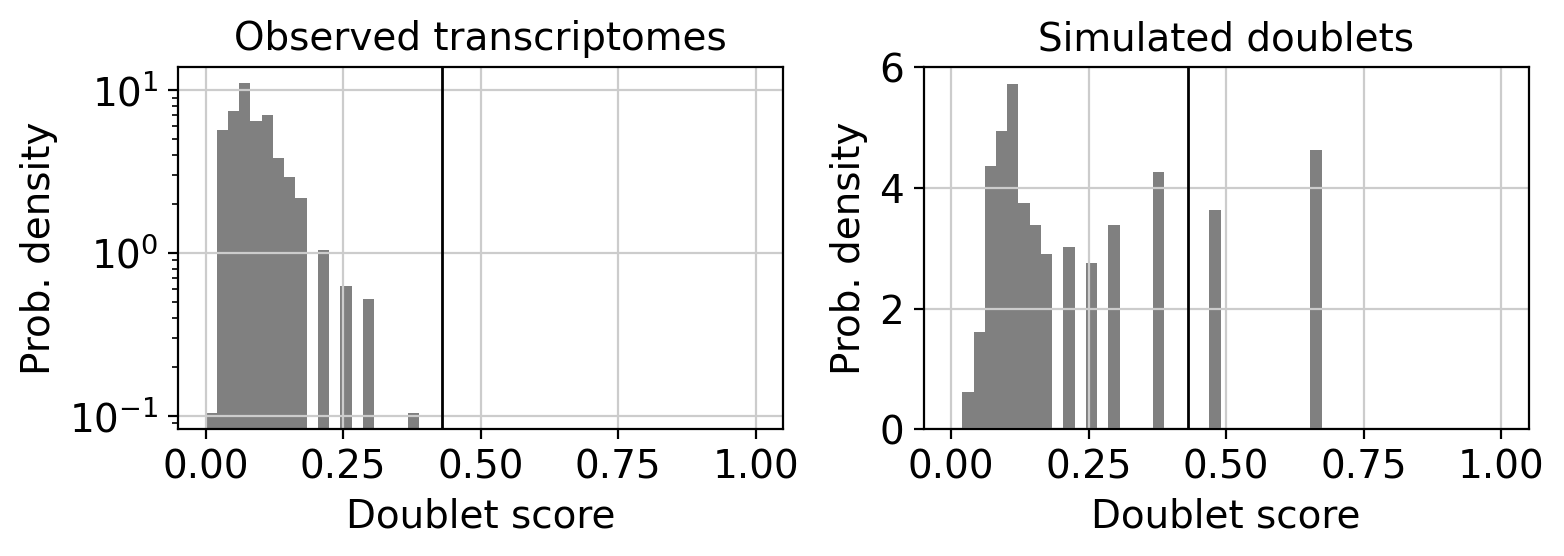

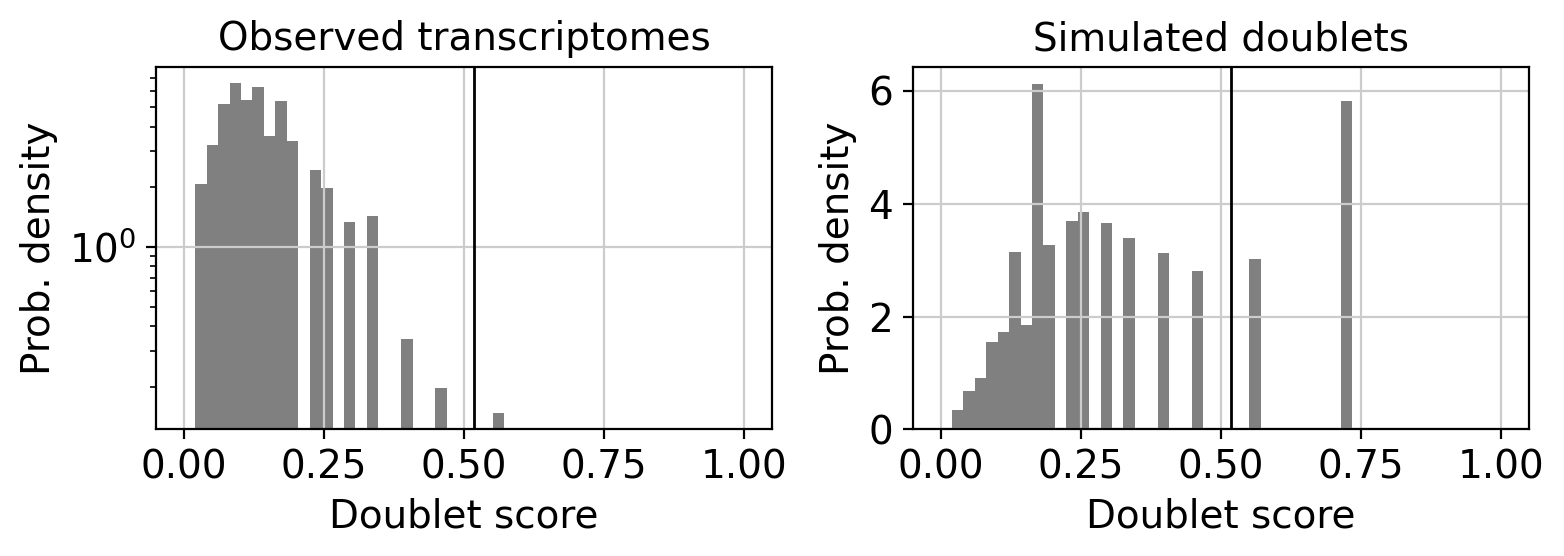

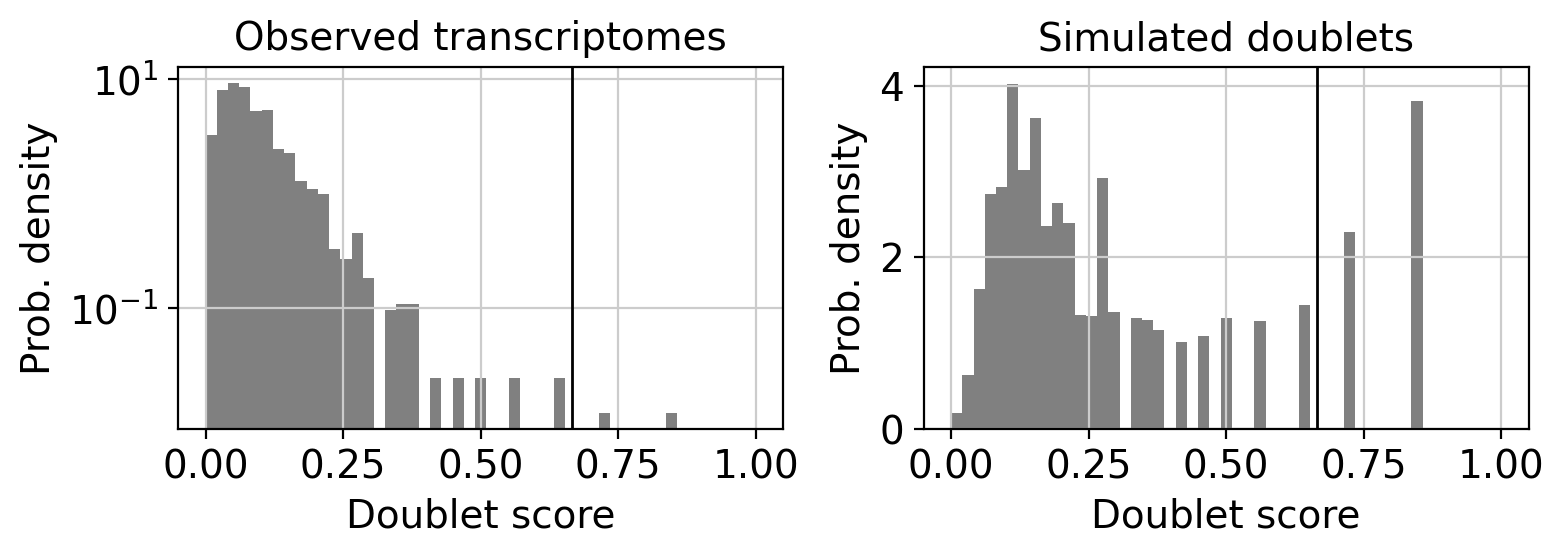

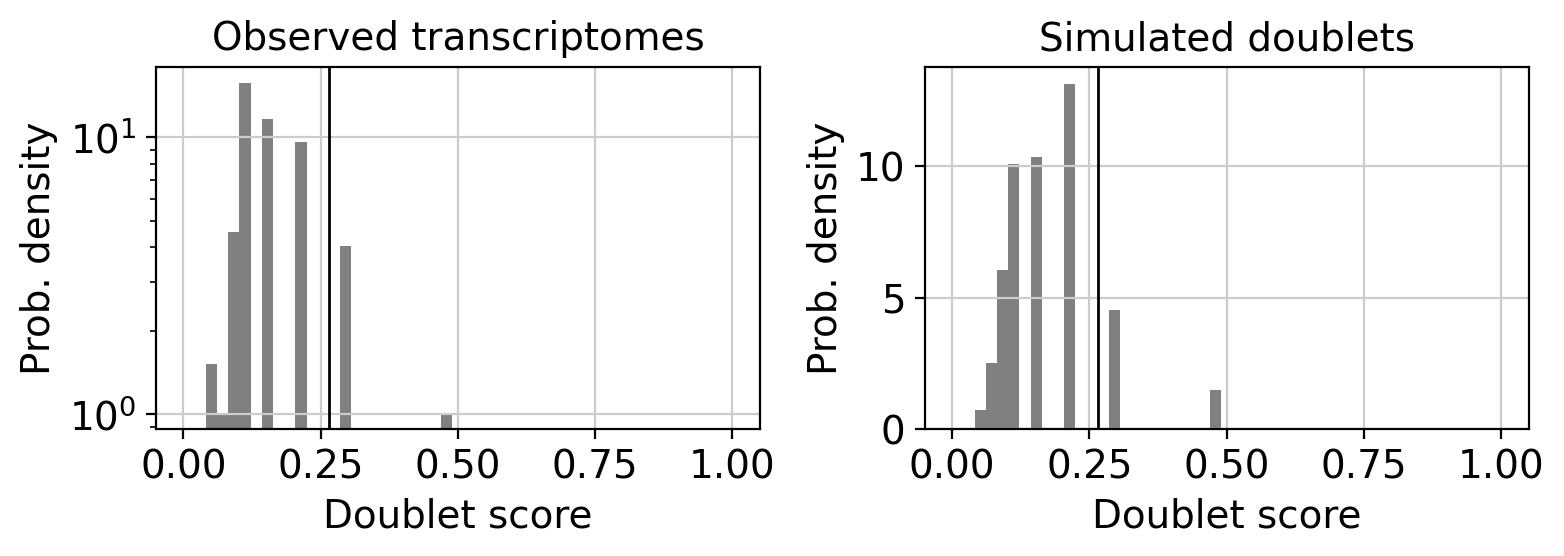

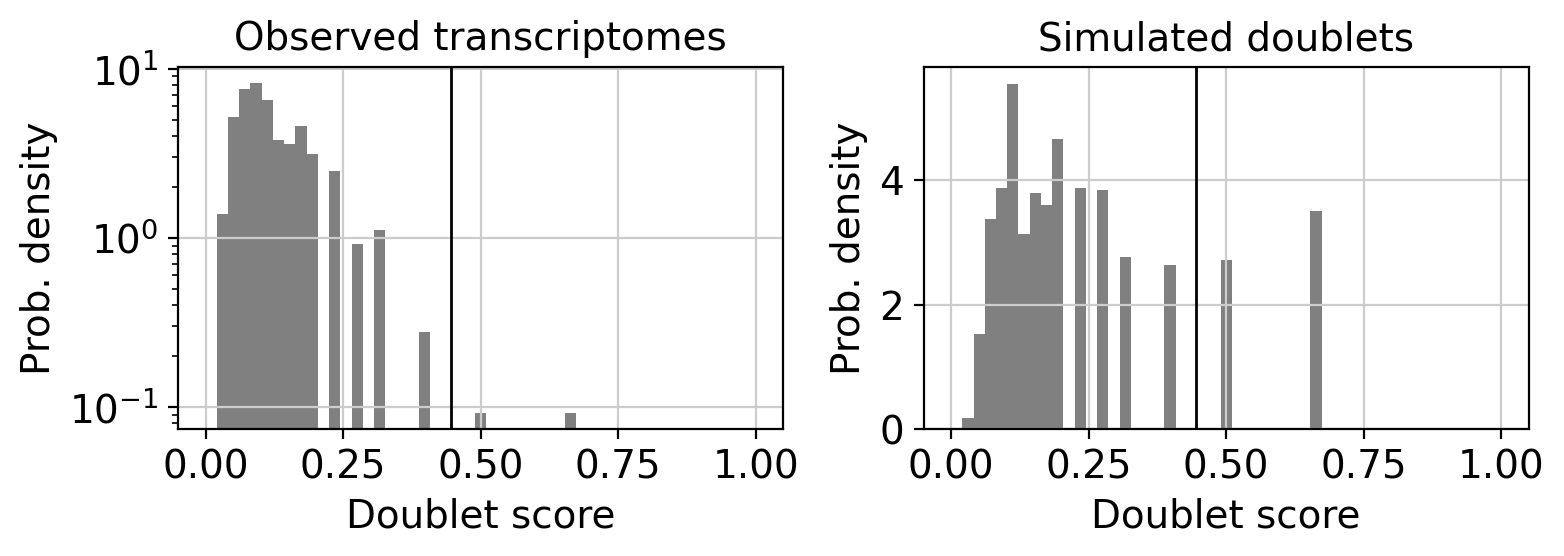

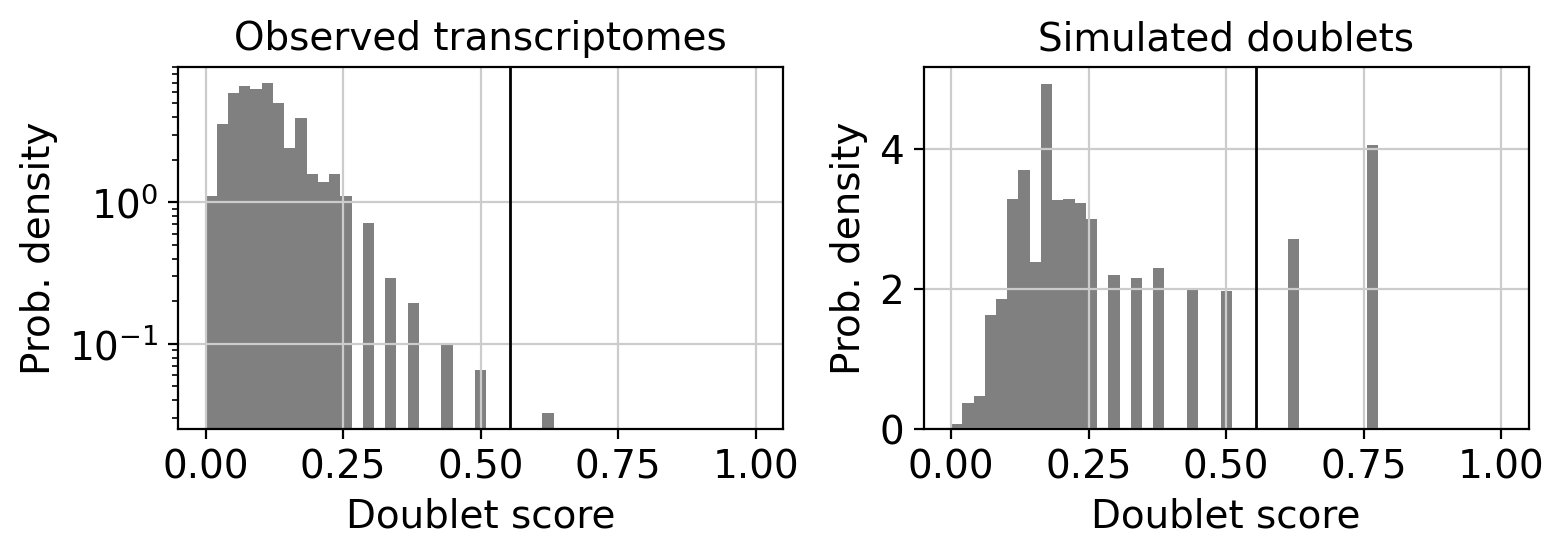

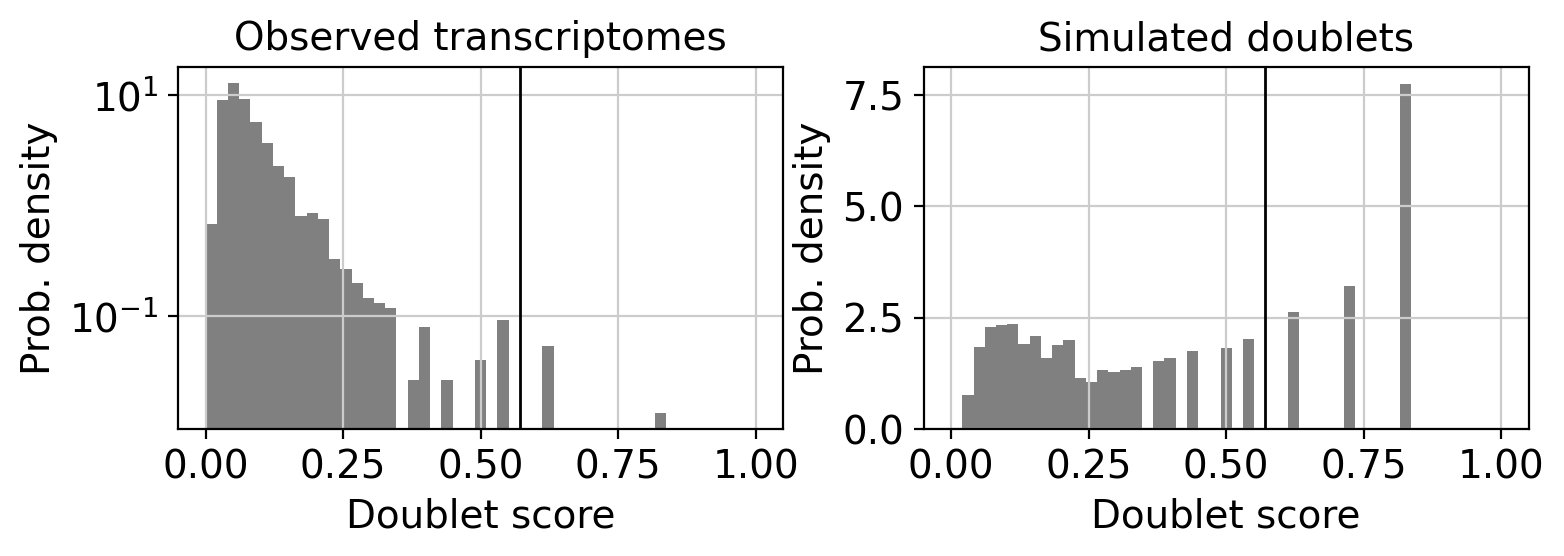

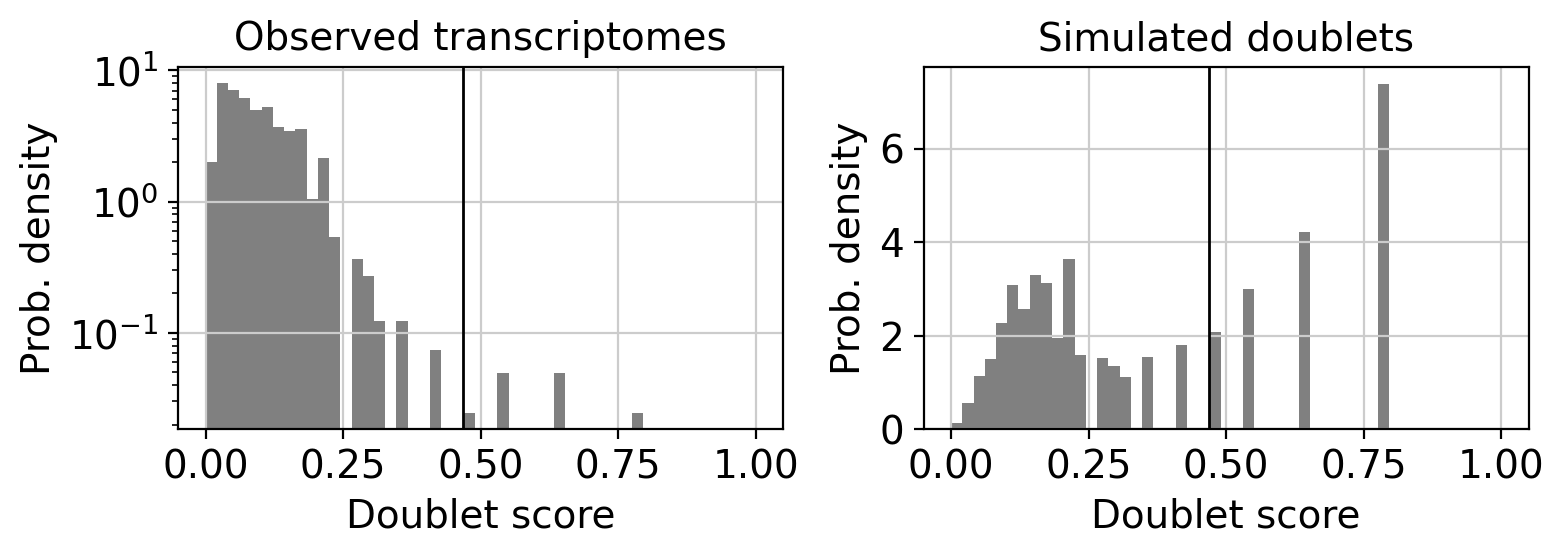

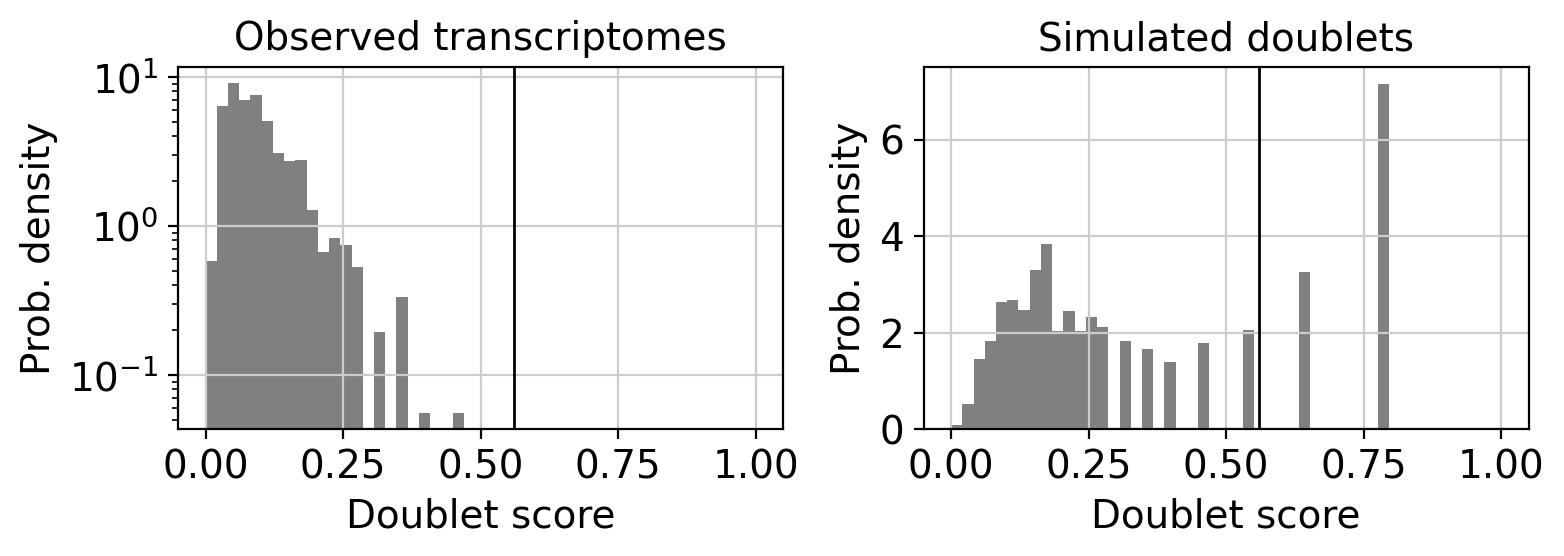

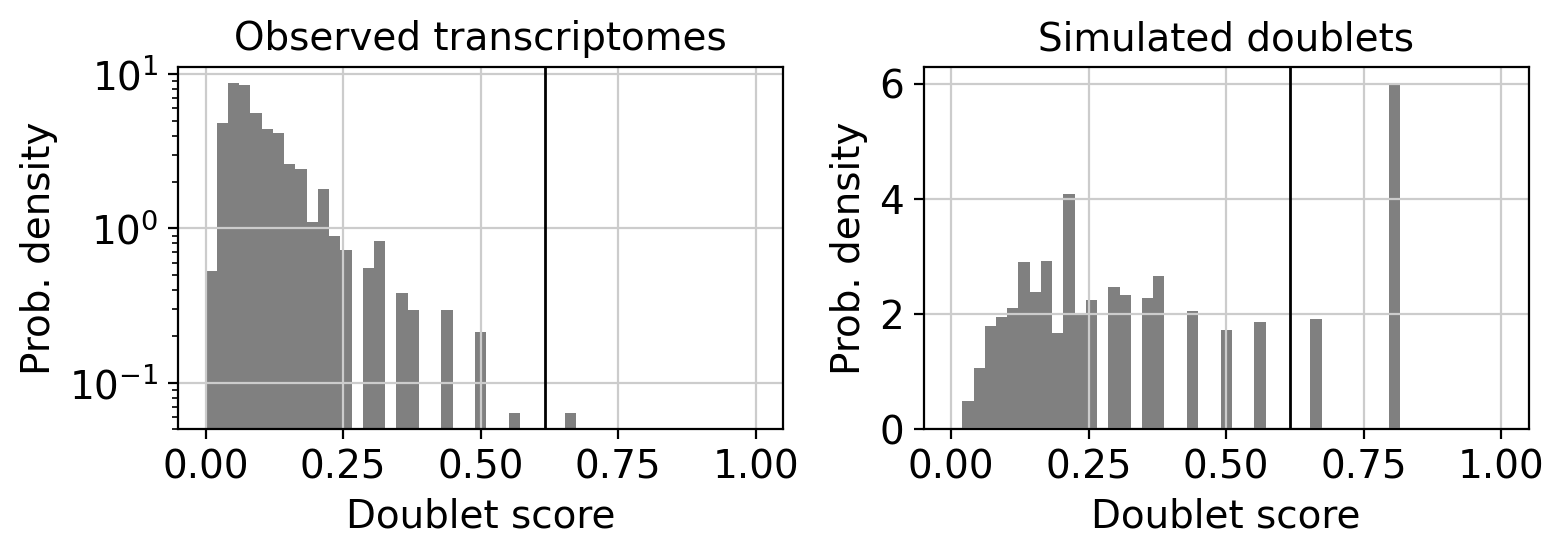

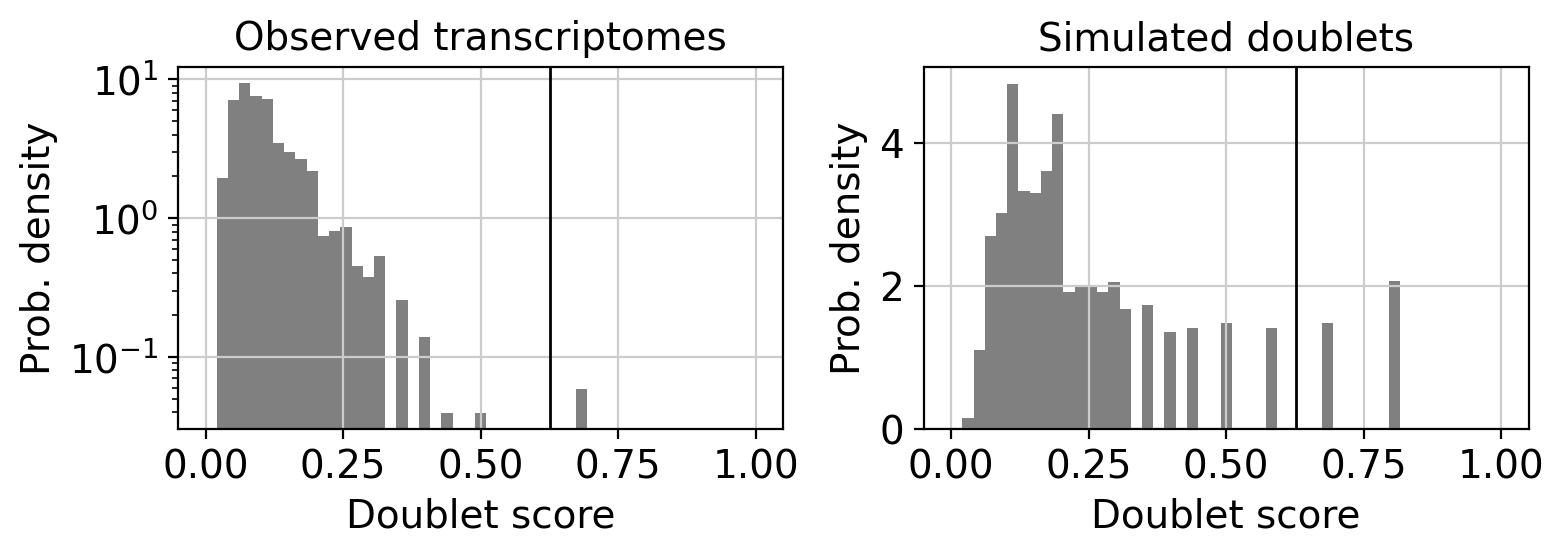

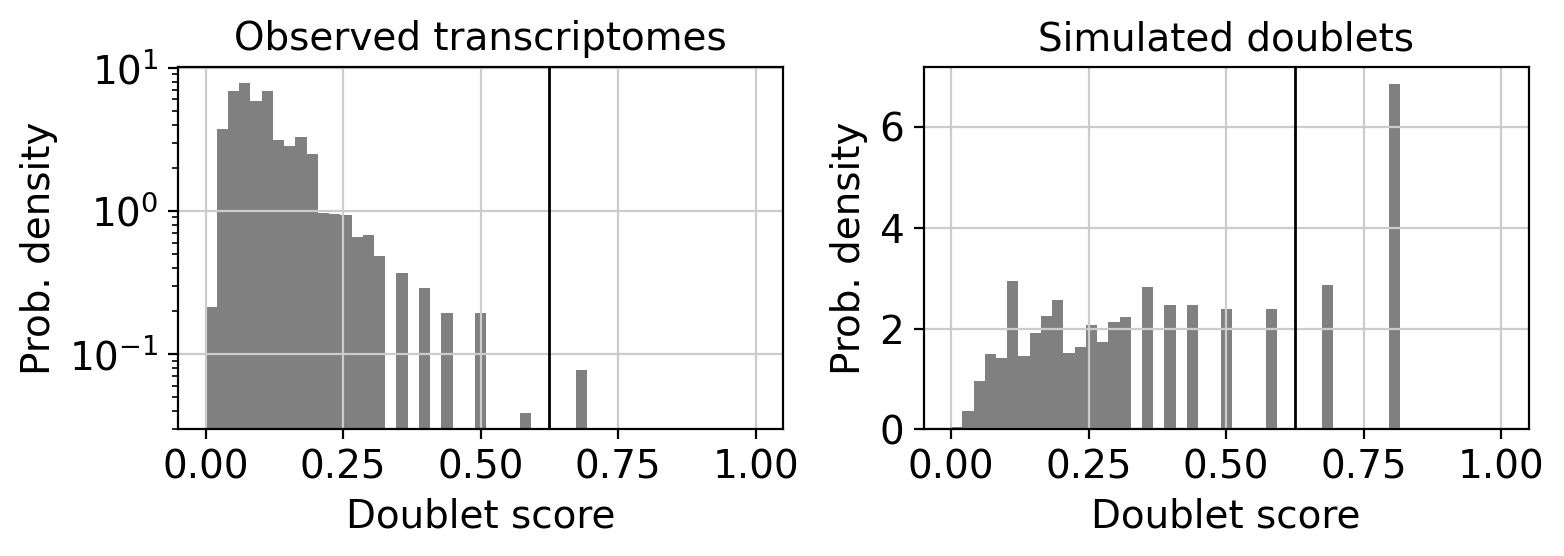

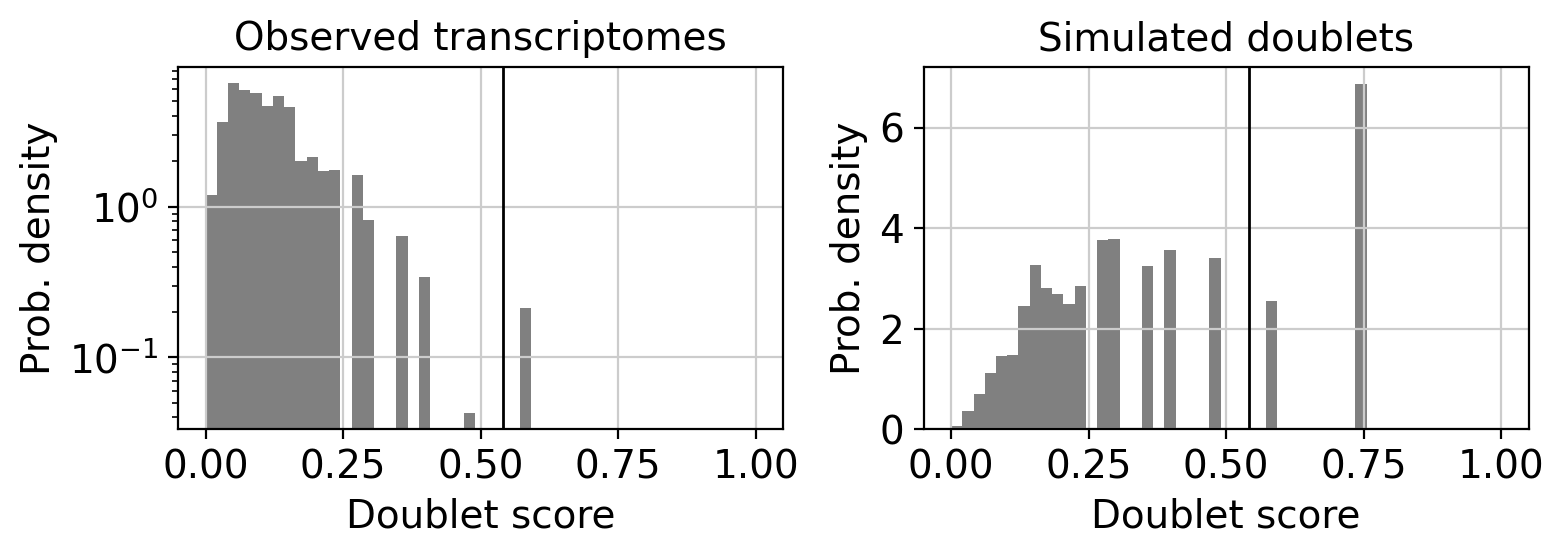

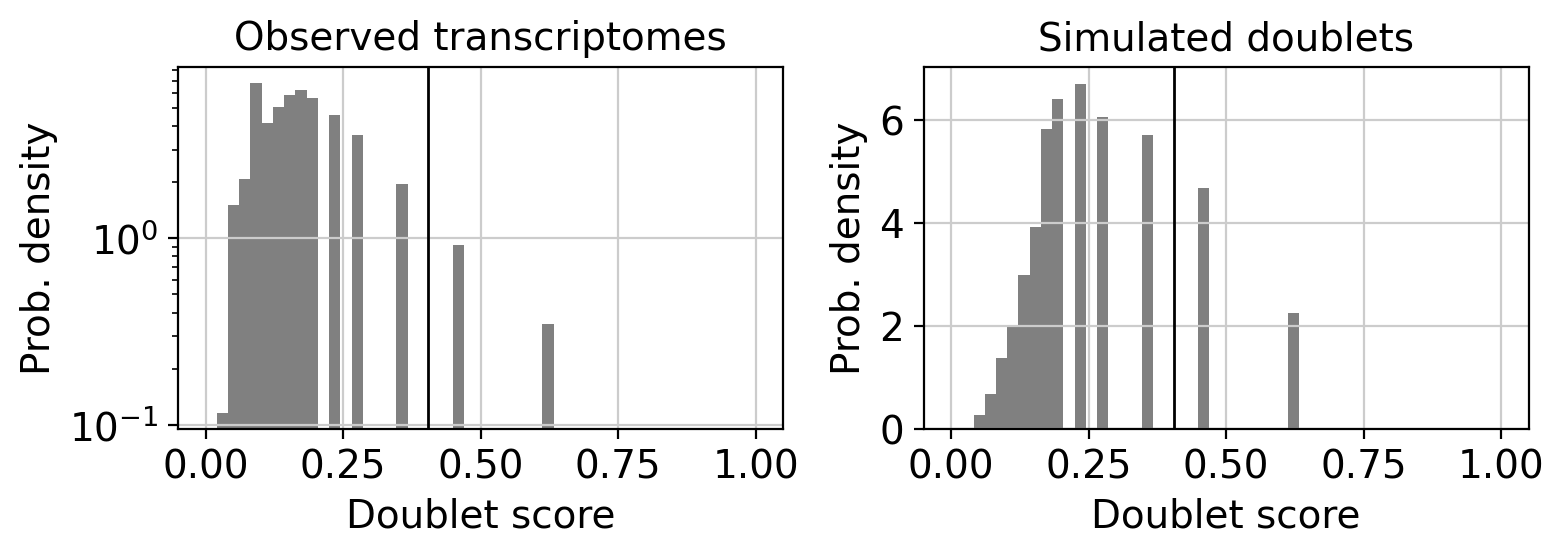

In [13]:
scrublet_concat = run_scrublet(
    adata, sample_col="Sample", cellbarcode_index_name="barcode"
)

In [14]:
scrublet_concat

,Sample,doublet_score,predicted_doublet
barcode,,,
P18_Colon_T_AAACGCTGTGTGTGTT-1,P18_Colon_T,0.120690,False
P18_Colon_T_AAAGTCCTCTAGACCA-1,P18_Colon_T,0.195122,False
P18_Colon_T_AACCTTTAGACAGTCG-1,P18_Colon_T,0.140127,False
P18_Colon_T_AACGAAAGTCTGTAAC-1,P18_Colon_T,0.140127,False
P18_Colon_T_ACCAAACTCCGGCAGT-1,P18_Colon_T,0.213974,False
...,...,...,...
P1_Colon_T_TTACCATCAATAGTGA,P1_Colon_T,0.142857,False
P1_Colon_T_TTACCGCTCGCCAATA,P1_Colon_T,0.084746,False
P1_Colon_T_TTCCGGTGTTTGTTGG,P1_Colon_T,0.032258,False


In [15]:
print(
    "Number of predicted doublets: ",
    scrublet_concat[scrublet_concat["predicted_doublet"] == True].shape[0],
)

Number of predicted doublets:  74


In [16]:
scrublet_concat.to_csv(
    DIR2SAVE.joinpath(scrublet_filename), sep="\t", index=True, header=True
)

In [17]:
## add scores to adata.obs
# add annot to .obs
adata.obs = adata.obs.merge(
    right=scrublet_concat[["doublet_score", "predicted_doublet"]],
    how="left",
    right_index=True,
    left_index=True,
)

### Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

In [18]:
# find genes that are mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# find genes that are ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

# compute QC metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=False, percent_top=None
)

In [19]:
print(
    adata.obs[
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]
    ].describe()
)

print(adata.var[["n_cells_by_counts", "total_counts"]].describe())

       n_genes_by_counts  total_counts  pct_counts_mt  pct_counts_ribo
count       29856.000000  29856.000000   29856.000000     29856.000000
mean         1122.022374   5006.949219       4.739141        23.500702
std           558.525228   6649.703125       4.136434        11.906727
min           201.000000    455.000000       0.000000         0.447094
25%           739.000000   1732.000000       2.326980        14.412384
50%          1022.000000   2817.000000       3.834277        23.700201
75%          1375.000000   4490.000000       5.985608        32.707002
max          4750.000000  76914.000000      88.166557        68.567451
       n_cells_by_counts  total_counts
count       20610.000000  2.061000e+04
mean         1625.380883  7.253122e+03
std          3444.849781  2.025756e+05
min             0.000000  0.000000e+00
25%            30.000000  3.100000e+01
50%           318.000000  3.575000e+02
75%          1676.750000  1.954000e+03
max         29799.000000  2.549102e+07


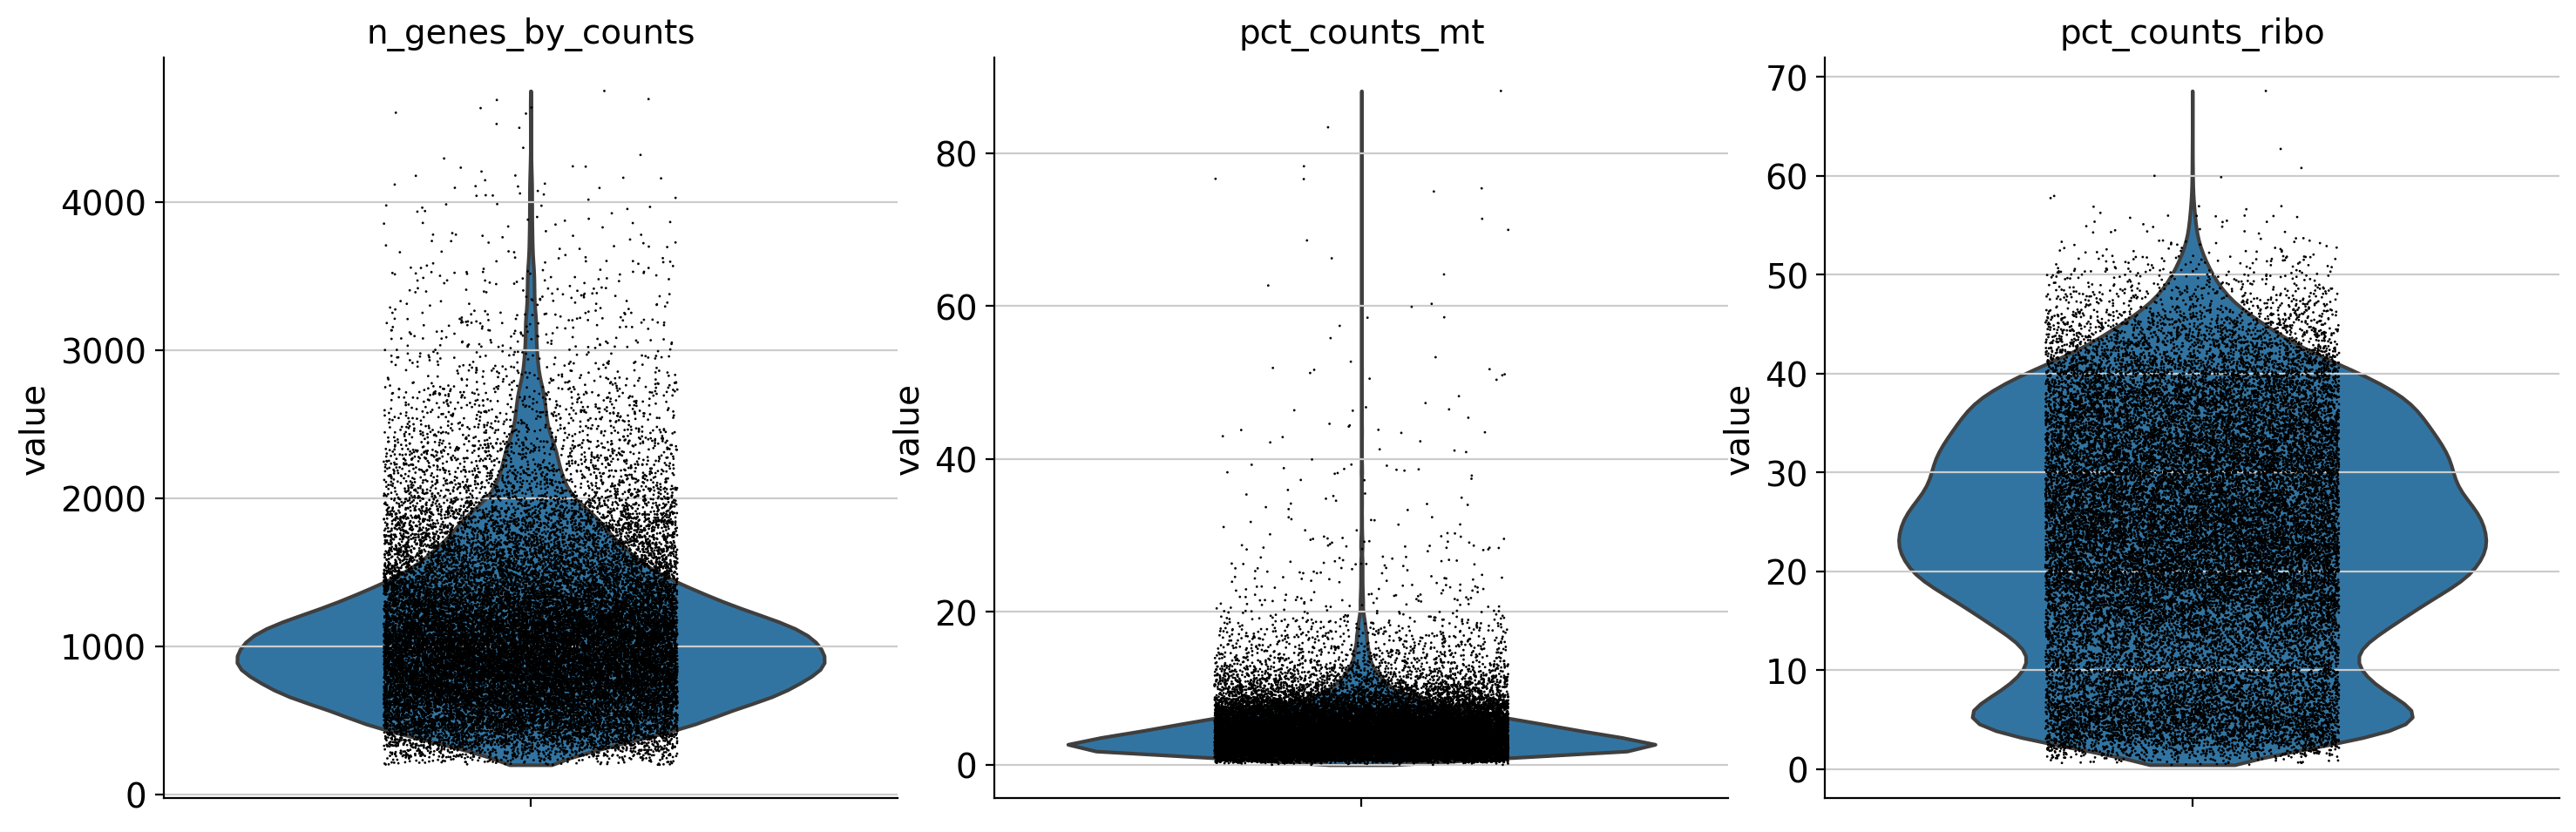

In [20]:
# violin plot of some distributions
sc.pl.violin(
    adata,
    keys=["n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.2,
    multi_panel=True,
    rotation=30,
    save="Wu2022_CRC_QC_covariates.pdf",
    show=True,
)

#### Filter cells according to identified QC thresholds:

* set threshold MT percent to 10%
* remove ribosomal and mitochondrial genes 
* remove cells with less than 300 genes

In [21]:
#### Filter cells according to identified QC thresholds:
print("Total number of cells: {:d}".format(adata.n_obs))

# remove cells with more than 20% MT genes
adata = adata[adata.obs.pct_counts_mt < 20, :].copy()
print("Number of cells after mt filter: {:d}".format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes=300)
print("Number of cells after gene filter: {:d}".format(adata.n_obs))

Total number of cells: 29856
Number of cells after mt filter: 29608
Number of cells after gene filter: 29298


#### Remove mt and ribo genes

In [22]:
print(adata.shape[1])
adata = adata[:, ~adata.var["mt"].values]
print("After mt genes removal: ", adata.shape[1])
adata = adata[:, ~adata.var["ribo"].values]
print("After ribo genes removal: ", adata.shape[1])

20610
After mt genes removal:  20597
After ribo genes removal:  20497


### Save to file 

In [23]:
adata.write(DIR2SAVE.joinpath("Wu2022_CRC_raw_scrublet_qc.h5ad"))